In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
!pip install tf2cv tensorflow>=2.0.0

In [ ]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10048126028888334560
physical_device_desc: "device: XLA_CPU device"

In [ ]:
#global consts
IMG_SIZE='137x236'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=128
DROP_OUT=0.0
FOLD=1
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_128 = (0.0692, 0.2051)
EXPERIMENT='sernext_fullsize_5fold_f1'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
DATASET_224='224x224-bengali.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
TRAIN_WITH_FOLD = 'train_with_fold.csv'
PRETRAINED = False
PRETRAINED_WEIGHTS = ''
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == 224: DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [ ]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [ ]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)

/content/drive/My Drive/kaggle/bengali/output/sernext_fullsize_5fold_f1/ already exists
/content/drive/My Drive/kaggle/bengali/output/sernext_fullsize_5fold_f1/chkp/ already exists


0

In [ ]:
if PRETRAINED: os.system('cp '+ '"'+OUTPUT_DIR+OUTPUT_SUBDIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [ ]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [ ]:
!ls train

137x236  bengali-full-size.zip	train_with_fold.csv


In [ ]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD).to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [ ]:
cons_unique=np.unique(train_np[:,3])
cons_y_train = train_np[:,3]
vowel_unique=np.unique(train_np[:,2])
vowel_y_train = train_np[:,2]
root_unique =np.unique(train_np[:,1])
root_y_train = train_np[:,1]

cons_class_weights = class_weight.compute_class_weight('balanced',
                                                 cons_unique,
                                                 cons_y_train)

vowel_class_weights = class_weight.compute_class_weight('balanced',
                                                 vowel_unique,
                                                 vowel_y_train)

root_class_weights = class_weight.compute_class_weight('balanced',
                                                 root_unique,
                                                 root_y_train)
cons_cw_dict=dict(enumerate(cons_class_weights))
vowel_cw_dict=dict(enumerate(vowel_class_weights))
root_cw_dict=dict(enumerate(root_class_weights))

model_cw={}
model_cw['root']=root_cw_dict
model_cw['vowel']=vowel_cw_dict
model_cw['consonant']=cons_cw_dict

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.125.108.122:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.125.108.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.125.108.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 1
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [ ]:
with strategy.scope():
  model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)
  opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)
  checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
  chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)
  chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
  if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
    print("Restored from {}".format(chkp_manager.latest_checkpoint))
    print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
  else:
    print("Initializing from scratch.")
  loss_dict={'root':    'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
  model.compile(optimizer=opt, loss=loss_dict, loss_weights=[4.0,1.0,1.0])


Initializing from scratch.


In [ ]:
if 0: model.summary()

In [ ]:
if 0:
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file=OUTPUT_DIR+'model3.png',show_shapes=True)

In [ ]:
if 0:
  for (n, layer) in enumerate(model.layers[1].layers):
    if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
      print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
      layer.activation = Mish(mish)
      print('-> {}'.format(layer.activation))

In [ ]:
TRAIN_DIR+PRETRAINED_WEIGHTS

'./train/'

In [ ]:
cutout_datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(p=0.95,s_l=0.05,s_h=0.3,r_1=0.8,r_2=1.2,v_l=0,v_h=0))

mcm_datagen = ImageDataGenerator()

In [ ]:
columns=["root_class","vowel_class", "cons_class"]

mcm_generator1 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

mcm_generator2 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")


cutout_generator = cutout_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

Found 160672 validated image filenames.
Found 160672 validated image filenames.
Found 160672 validated image filenames.


In [ ]:
def g3_generator_fs2(gen1,gen2, gen3,h=137,w=236,st=STATS_FS):
    while True:
        p = np.random.rand()
        if p>0.8:
            batch = next(gen3)
            x_res,y_res = prep_batch_fs_shuffled(batch,st=st)
        else:
            batch1 = next(gen1)
            batch2 = next(gen2)
            q = np.random.rand()
            if q>0.3:
                x_res,y_res = mix_batches_fs_shuffled(batch1,batch2,alpha=0.1,st=st)
            else:
                x_res,y_res = cutmix_batches_fs2_shuffled(batch1,batch2,alpha=0.8,h=h,w=w,st=st)
        yield x_res,y_res[0]

In [ ]:
if 0:
  mixup_datagen=mixup_data_gen(aux_data_gen(mcm_generator1),aux_data_gen(mcm_generator2))
  cutout_datagen=aux_data_gen(cutout_generator)
  h_datagen=hybrid_data_gen(mixup_datagen,cutout_datagen)
  h2_datagen=h_generator(mcm_generator1,mcm_generator2,cutout_generator)
  hmcm_datagen=hmcm_generator(mcm_generator1,mcm_generator2)
  g3_datagen = g3_generator(mcm_generator1,mcm_generator2,cutout_generator)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)
  cpsm_datagen_fs = cpsm_generator_fs(mcm_generator1,mcm_generator2,cutout_generator, st=STATS_FS)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)

g3_datagen_fs2 = g3_generator_fs2(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)

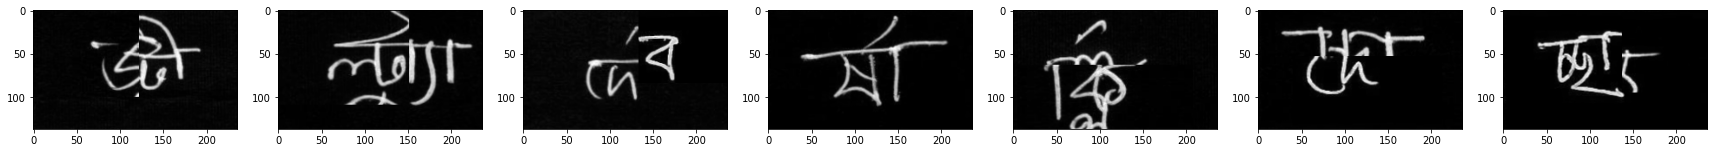

In [ ]:
if 1: 
  batch_x,y = next(g3_datagen_fs2)
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(1, 7, figsize=(30, 30))
  for i in range(7):
    axs[i].imshow(batch_x[i,:,:,0], cmap='gray')
  plt.show()

In [ ]:
y.shape

(64, 168)

In [ ]:
if 0: opt = Lookahead(tf.keras.optimizers.SGD(learning_rate=LR_MAX, momentum=0.9,nesterov=True))

opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)

In [ ]:
checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)

In [ ]:
chkp_manager.latest_checkpoint

'/content/drive/My Drive/kaggle/bengali/output/sernext_fullsize_5fold_f1/chkp/ckpt-71'

In [ ]:
chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
  print("Restored from {}".format(chkp_manager.latest_checkpoint))
  print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
else:
  print("Initializing from scratch.")

Restored from /content/drive/My Drive/kaggle/bengali/output/sernext_fullsize_5fold_f1/chkp/ckpt-71
Lastest epoch 71


In [ ]:
def ohem_loss(alpha=0.1):

    def loss(ytrue,ypred):
      result = tf.keras.backend.categorical_crossentropy(ytrue, ypred, axis=-1)
      index =  tf.keras.backend.greater(result, alpha)
      cast = tf.cast(index, tf.float32)
      return result*cast
    
    return loss

In [ ]:
loss_dict={'root':    ohem_loss(alpha=2.0),
           'vowel':   ohem_loss(alpha=2.0),
           'consonant':ohem_loss(alpha=2.0)}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[4.0,1.0,1.0])

In [ ]:
loss_dict={'root':    'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[4.0,1.0,1.0])

In [ ]:
dataset = tf.data.Dataset.from_generator(lambda: g3_datagen_fs2, 
                                         (tf.float32,tf.float32),
                                         (tf.TensorShape([]), tf.TensorShape([])))

In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
list(dataset.take(1).as_numpy_iterator())

NotFoundError: ignored

In [ ]:
initial_epoch = checkpoint.latest_epoch.numpy()

print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')
#ca_shed = CosineAnnealingScheduler(T_max=100, eta_max=0.0001, eta_min=0.000001,verbose=1, initial_epoch=59)
#rolrplt = tf.keras.callbacks.ReduceLROnPlateau(monitor='kaggle',mode='max', patience=5, verbose=1, factor=0.5, min_lr=LR_MIN)


suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)


kv = KaggleValidationFS(valid_df,
                      batch_size=512,
                      vals_per_epoch=4,
                      train_steps=train_m//BATCH_SIZE+1,
                      logfile=EXPERIMENT_DIR+'log_kr_'+suffix+'.csv',
                      initial_epoch=initial_epoch,
                      suffix = suffix,
                      train_img_dir=TRAIN_IMG_DIR,
                      output_dir=EXPERIMENT_DIR,
                      thresholds=[0.985,0.99,0.989],
                      chkp_manager=chkp_manager,
                      in_shape=[HEIGHT,WIDTH],
                      st=STATS_FS)

tf.keras.backend.set_value(model.optimizer.lr, 0.00001)
cbs = [kv]

history=model.fit(dataset,
                  epochs=EPOCHS,
                  steps_per_epoch=train_m//BATCH_SIZE+1,
                  callbacks=cbs,
                  verbose=1)

epochs trained: 0. start training epoch 1...


TypeError: ignored

In [ ]:
model.optimizer.get_config()